In [ ]:
# !sudo apt install swig

In [ ]:
# !pip install quantstats
# !pip install scikit-learn
# !pip install torch
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
#!pip install vmdpy

In [2]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [17]:
TEST_SET = [
    "AAPL", "CVX", "GS", "JNJ",
    "JPM", "MSFT", "PFE", "PG",
    "UL", "XOM"
]
START_DATE = '2013-01-01'
END_DATE = '2023-12-31'
print(len(TEST_SET))

portfolio_raw_df = YahooDownloader(start_date = START_DATE,
                                end_date = END_DATE,
                                ticker_list = TEST_SET).fetch_data()
portfolio_raw_df
portfolio_raw_df.groupby("tic").count()
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= START_DATE) & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]
df_portfolio_2023 = df_portfolio[(df_portfolio["date"] >= "2023-01-01") & (df_portfolio["date"] < END_DATE)]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

10



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/Users/ethan/Documents/GitHub/DSE4212/venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.38369243 0.24161592 0.40684028 ... 0.03291756 0.02330824 0.02918077]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
/Users/ethan/Documents/GitHub/DSE4212/venv/lib/python3.10/site-packages/finrl/meta/preprocessor/preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 0.5  0.75 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_

Shape of DataFrame:  (27680, 8)


In [29]:
import pandas as pd
from vmdpy import VMD

def apply_vmd_to_ticker(df, alpha=5000, tau=0, K=3, DC=0, init=1, tol=1e-7):
    """Applies VMD to the 'close' price for each ticker in the dataframe
    and handles any length mismatch issues."""
    vmd_features = []
    
    # Apply VMD per ticker
    for tic in df['tic'].unique():
        tic_df = df[df['tic'] == tic].copy()  # Filter data for the current ticker
        close_prices = tic_df['close'].to_numpy()  # Extract close prices
        
        # Perform VMD on the close prices
        u, _, _ = VMD(close_prices, alpha, tau, K, DC, init, tol)
        
        # Check if the lengths match, and if not, align them
        if u.shape[1] != len(tic_df):
            print(f"Length mismatch for {tic}: VMD output has {u.shape[1]} points, expected {len(tic_df)}")
            min_len = min(u.shape[1], len(tic_df))
            tic_df = tic_df.iloc[:min_len]  # Truncate the dataframe to match VMD output length
            u = u[:, :min_len]  # Truncate VMD output if necessary
        
        # Assign VMD modes to columns
        for k in range(K):
            tic_df[f'vmd_mode_{k}'] = u[k, :]
        
        # Append the dataframe with VMD modes
        vmd_features.append(tic_df)
    
    # Concatenate all VMD modes into one dataframe
    vmd_df = pd.concat(vmd_features, axis=0)
    
    return vmd_df

# Apply VMD to the training data
df_portfolio_train_vmd = apply_vmd_to_ticker(df_portfolio_train)
df_portfolio_2021_vmd = apply_vmd_to_ticker(df_portfolio_2021)
df_portfolio_2022_vmd = apply_vmd_to_ticker(df_portfolio_2022)
df_portfolio_2023_vmd = apply_vmd_to_ticker(df_portfolio_2023)


Length mismatch for AAPL: VMD output has 250 points, expected 251
Length mismatch for CVX: VMD output has 250 points, expected 251
Length mismatch for GS: VMD output has 250 points, expected 251
Length mismatch for JNJ: VMD output has 250 points, expected 251
Length mismatch for JPM: VMD output has 250 points, expected 251
Length mismatch for MSFT: VMD output has 250 points, expected 251
Length mismatch for PFE: VMD output has 250 points, expected 251
Length mismatch for PG: VMD output has 250 points, expected 251
Length mismatch for UL: VMD output has 250 points, expected 251
Length mismatch for XOM: VMD output has 250 points, expected 251
Length mismatch for AAPL: VMD output has 250 points, expected 251
Length mismatch for CVX: VMD output has 250 points, expected 251
Length mismatch for GS: VMD output has 250 points, expected 251
Length mismatch for JNJ: VMD output has 250 points, expected 251
Length mismatch for JPM: VMD output has 250 points, expected 251
Length mismatch for MSFT: 

In [26]:
environment_vmd = PortfolioOptimizationEnv(
    df=df_portfolio_train_vmd,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low", "vmd_mode_0", "vmd_mode_1", "vmd_mode_2"],  # Add VMD modes as features
    normalize_df=None
)

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": 50,
    "initial_features": 6
}

model = DRLAgent(environment_vmd).get_model("pg", device, model_kwargs, policy_kwargs)

In [20]:
DRLAgent.train_model(model, episodes=50)


  0%|          | 0/50 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 269573.375
Final accumulative portfolio value: 2.69573375
Maximum DrawDown: -0.29576533183776543
Sharpe ratio: 0.9155805142234241


  2%|▏         | 1/50 [00:07<06:12,  7.61s/it]

Initial portfolio value:100000
Final portfolio value: 349540.0625
Final accumulative portfolio value: 3.495400625
Maximum DrawDown: -0.22688732654509525
Sharpe ratio: 1.1550429032575102


  4%|▍         | 2/50 [00:15<06:15,  7.83s/it]

Initial portfolio value:100000
Final portfolio value: 520448.53125
Final accumulative portfolio value: 5.2044853125
Maximum DrawDown: -0.19395511735412463
Sharpe ratio: 1.3759865590416995


  6%|▌         | 3/50 [00:23<06:10,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 642558.75
Final accumulative portfolio value: 6.4255875
Maximum DrawDown: -0.23185715288833908
Sharpe ratio: 1.3503669789899733


  8%|▊         | 4/50 [00:31<06:01,  7.87s/it]

Initial portfolio value:100000
Final portfolio value: 580656.1875
Final accumulative portfolio value: 5.806561875
Maximum DrawDown: -0.1870050889880941
Sharpe ratio: 1.4754122281073996


 10%|█         | 5/50 [00:39<05:54,  7.88s/it]

Initial portfolio value:100000
Final portfolio value: 751986.5
Final accumulative portfolio value: 7.519865
Maximum DrawDown: -0.21996633543487998
Sharpe ratio: 1.5079822185124538


 12%|█▏        | 6/50 [00:46<05:37,  7.66s/it]

Initial portfolio value:100000
Final portfolio value: 1131520.25
Final accumulative portfolio value: 11.3152025
Maximum DrawDown: -0.2094727988725983
Sharpe ratio: 1.5134225306553022


 14%|█▍        | 7/50 [00:53<05:22,  7.50s/it]

Initial portfolio value:100000
Final portfolio value: 1078124.75
Final accumulative portfolio value: 10.7812475
Maximum DrawDown: -0.19256967394753122
Sharpe ratio: 1.5876605935407442


 16%|█▌        | 8/50 [01:00<05:11,  7.41s/it]

Initial portfolio value:100000
Final portfolio value: 1189159.375
Final accumulative portfolio value: 11.89159375
Maximum DrawDown: -0.2740142474737769
Sharpe ratio: 1.428604058982108


 18%|█▊        | 9/50 [01:08<05:00,  7.33s/it]

Initial portfolio value:100000
Final portfolio value: 1124385.5
Final accumulative portfolio value: 11.243855
Maximum DrawDown: -0.17441257942266108
Sharpe ratio: 1.7181505110411501


 20%|██        | 10/50 [01:15<04:51,  7.29s/it]

Initial portfolio value:100000
Final portfolio value: 999381.3125
Final accumulative portfolio value: 9.993813125
Maximum DrawDown: -0.2923395112254443
Sharpe ratio: 1.4089526922591953


 22%|██▏       | 11/50 [01:22<04:42,  7.25s/it]

Initial portfolio value:100000
Final portfolio value: 1205127.25
Final accumulative portfolio value: 12.0512725
Maximum DrawDown: -0.17178723724503586
Sharpe ratio: 1.7105975342291555


 24%|██▍       | 12/50 [01:29<04:36,  7.28s/it]

Initial portfolio value:100000
Final portfolio value: 1086814.75
Final accumulative portfolio value: 10.8681475
Maximum DrawDown: -0.2880266558960446
Sharpe ratio: 1.3991200750625632


 26%|██▌       | 13/50 [01:36<04:28,  7.25s/it]

Initial portfolio value:100000
Final portfolio value: 1441060.25
Final accumulative portfolio value: 14.4106025
Maximum DrawDown: -0.2909534129780733
Sharpe ratio: 1.5049504681082566


 28%|██▊       | 14/50 [01:44<04:20,  7.24s/it]

Initial portfolio value:100000
Final portfolio value: 1575604.625
Final accumulative portfolio value: 15.75604625
Maximum DrawDown: -0.2732558838032021
Sharpe ratio: 1.5318240925347055


 30%|███       | 15/50 [01:51<04:13,  7.24s/it]

Initial portfolio value:100000
Final portfolio value: 1600424.75
Final accumulative portfolio value: 16.0042475
Maximum DrawDown: -0.27253842677964235
Sharpe ratio: 1.523666159356214


 32%|███▏      | 16/50 [01:58<04:05,  7.23s/it]

Initial portfolio value:100000
Final portfolio value: 1637699.0
Final accumulative portfolio value: 16.37699
Maximum DrawDown: -0.2066884289870471
Sharpe ratio: 1.6824517505594851


 34%|███▍      | 17/50 [02:05<03:58,  7.21s/it]

Initial portfolio value:100000
Final portfolio value: 1586958.375
Final accumulative portfolio value: 15.86958375
Maximum DrawDown: -0.18192001294993954
Sharpe ratio: 1.7594775007558543


 36%|███▌      | 18/50 [02:13<03:51,  7.22s/it]

Initial portfolio value:100000
Final portfolio value: 1913542.875
Final accumulative portfolio value: 19.13542875
Maximum DrawDown: -0.2882562617054224
Sharpe ratio: 1.6088746927578026


 38%|███▊      | 19/50 [02:20<03:43,  7.21s/it]

Initial portfolio value:100000
Final portfolio value: 1873646.0
Final accumulative portfolio value: 18.73646
Maximum DrawDown: -0.27766767579736096
Sharpe ratio: 1.5968614431501755


 40%|████      | 20/50 [02:27<03:36,  7.21s/it]

Initial portfolio value:100000
Final portfolio value: 1969102.0
Final accumulative portfolio value: 19.69102
Maximum DrawDown: -0.20599249922642537
Sharpe ratio: 1.7327723029150524


 42%|████▏     | 21/50 [02:34<03:29,  7.23s/it]

Initial portfolio value:100000
Final portfolio value: 2573937.0
Final accumulative portfolio value: 25.73937
Maximum DrawDown: -0.20456631358401944
Sharpe ratio: 1.8739911284702557


 44%|████▍     | 22/50 [02:42<03:23,  7.27s/it]

Initial portfolio value:100000
Final portfolio value: 2714041.0
Final accumulative portfolio value: 27.14041
Maximum DrawDown: -0.31759503446492265
Sharpe ratio: 1.7395323642752003


 46%|████▌     | 23/50 [02:49<03:15,  7.25s/it]

Initial portfolio value:100000
Final portfolio value: 3069788.5
Final accumulative portfolio value: 30.697885
Maximum DrawDown: -0.2910109517670624
Sharpe ratio: 1.8126623105033295


 48%|████▊     | 24/50 [02:56<03:08,  7.24s/it]

Initial portfolio value:100000
Final portfolio value: 2080107.0
Final accumulative portfolio value: 20.80107
Maximum DrawDown: -0.18200936560199965
Sharpe ratio: 1.8083456024249605


 50%|█████     | 25/50 [03:03<03:00,  7.22s/it]

Initial portfolio value:100000
Final portfolio value: 2487289.75
Final accumulative portfolio value: 24.8728975
Maximum DrawDown: -0.31310999327968647
Sharpe ratio: 1.7051100200566456


 52%|█████▏    | 26/50 [03:10<02:53,  7.22s/it]

Initial portfolio value:100000
Final portfolio value: 2790574.5
Final accumulative portfolio value: 27.905745
Maximum DrawDown: -0.3047435179078394
Sharpe ratio: 1.7786870056417443


 54%|█████▍    | 27/50 [03:18<02:45,  7.21s/it]

Initial portfolio value:100000
Final portfolio value: 3046855.5
Final accumulative portfolio value: 30.468555
Maximum DrawDown: -0.2891935354723516
Sharpe ratio: 1.847271076412569


 56%|█████▌    | 28/50 [03:25<02:39,  7.23s/it]

Initial portfolio value:100000
Final portfolio value: 3736683.0
Final accumulative portfolio value: 37.36683
Maximum DrawDown: -0.30362062499446985
Sharpe ratio: 1.9309680915908027


 58%|█████▊    | 29/50 [03:32<02:31,  7.23s/it]

Initial portfolio value:100000
Final portfolio value: 3593869.25
Final accumulative portfolio value: 35.9386925
Maximum DrawDown: -0.26430637540054314
Sharpe ratio: 1.9280280267757968


 60%|██████    | 30/50 [03:39<02:25,  7.25s/it]

Initial portfolio value:100000
Final portfolio value: 3664320.5
Final accumulative portfolio value: 36.643205
Maximum DrawDown: -0.24890959275817337
Sharpe ratio: 2.0554731834142372


 62%|██████▏   | 31/50 [03:47<02:18,  7.31s/it]

Initial portfolio value:100000
Final portfolio value: 2573658.5
Final accumulative portfolio value: 25.736585
Maximum DrawDown: -0.2940108072508473
Sharpe ratio: 1.8401287773901558


 64%|██████▍   | 32/50 [03:55<02:13,  7.44s/it]

Initial portfolio value:100000
Final portfolio value: 3253263.75
Final accumulative portfolio value: 32.5326375
Maximum DrawDown: -0.29279327214413453
Sharpe ratio: 1.9297525353893608


 66%|██████▌   | 33/50 [04:02<02:06,  7.43s/it]

Initial portfolio value:100000
Final portfolio value: 3482607.75
Final accumulative portfolio value: 34.8260775
Maximum DrawDown: -0.2865469811716992
Sharpe ratio: 1.8928124661719294


 68%|██████▊   | 34/50 [04:09<01:58,  7.39s/it]

Initial portfolio value:100000
Final portfolio value: 4113471.5
Final accumulative portfolio value: 41.134715
Maximum DrawDown: -0.16608440583746764
Sharpe ratio: 2.1751459569981795


 70%|███████   | 35/50 [04:17<01:51,  7.46s/it]

Initial portfolio value:100000
Final portfolio value: 1474022.75
Final accumulative portfolio value: 14.7402275
Maximum DrawDown: -0.40731375482390697
Sharpe ratio: 1.4789630464831798


 72%|███████▏  | 36/50 [04:24<01:43,  7.37s/it]

Initial portfolio value:100000
Final portfolio value: 3694458.0
Final accumulative portfolio value: 36.94458
Maximum DrawDown: -0.2763682519268852
Sharpe ratio: 1.8898826224555432


 74%|███████▍  | 37/50 [04:31<01:35,  7.33s/it]

Initial portfolio value:100000
Final portfolio value: 3488757.0
Final accumulative portfolio value: 34.88757
Maximum DrawDown: -0.2657253984618356
Sharpe ratio: 1.8243922363418523


 76%|███████▌  | 38/50 [04:39<01:27,  7.32s/it]

Initial portfolio value:100000
Final portfolio value: 4001810.5
Final accumulative portfolio value: 40.018105
Maximum DrawDown: -0.20090273542557857
Sharpe ratio: 2.031411308743415


 78%|███████▊  | 39/50 [04:46<01:21,  7.42s/it]

Initial portfolio value:100000
Final portfolio value: 3343701.25
Final accumulative portfolio value: 33.4370125
Maximum DrawDown: -0.29759626773315784
Sharpe ratio: 1.925910200762848


 80%|████████  | 40/50 [04:53<01:13,  7.37s/it]

Initial portfolio value:100000
Final portfolio value: 4347747.5
Final accumulative portfolio value: 43.477475
Maximum DrawDown: -0.18836306935135594
Sharpe ratio: 2.0127640502493382


 82%|████████▏ | 41/50 [05:01<01:06,  7.39s/it]

Initial portfolio value:100000
Final portfolio value: 2119008.5
Final accumulative portfolio value: 21.190085
Maximum DrawDown: -0.28266764261117727
Sharpe ratio: 1.7158348161102595


 84%|████████▍ | 42/50 [05:08<00:58,  7.32s/it]

Initial portfolio value:100000
Final portfolio value: 2898151.5
Final accumulative portfolio value: 28.981515
Maximum DrawDown: -0.30332345835393903
Sharpe ratio: 1.785453749675558


 86%|████████▌ | 43/50 [05:15<00:51,  7.35s/it]

Initial portfolio value:100000
Final portfolio value: 2868807.0
Final accumulative portfolio value: 28.68807
Maximum DrawDown: -0.29982272765062423
Sharpe ratio: 1.8502971236620354


 88%|████████▊ | 44/50 [05:23<00:43,  7.29s/it]

Initial portfolio value:100000
Final portfolio value: 3564400.25
Final accumulative portfolio value: 35.6440025
Maximum DrawDown: -0.29339961837668005
Sharpe ratio: 1.8403062585546186


 90%|█████████ | 45/50 [05:30<00:36,  7.30s/it]

Initial portfolio value:100000
Final portfolio value: 2592612.75
Final accumulative portfolio value: 25.9261275
Maximum DrawDown: -0.28284032858269226
Sharpe ratio: 1.823772827326062


 92%|█████████▏| 46/50 [05:37<00:29,  7.25s/it]

Initial portfolio value:100000
Final portfolio value: 3060432.5
Final accumulative portfolio value: 30.604325
Maximum DrawDown: -0.2778163028797491
Sharpe ratio: 1.7971154128184568


 94%|█████████▍| 47/50 [05:45<00:21,  7.33s/it]

Initial portfolio value:100000
Final portfolio value: 4070707.25
Final accumulative portfolio value: 40.7070725
Maximum DrawDown: -0.2741826852352244
Sharpe ratio: 2.0122088304174497


 96%|█████████▌| 48/50 [05:52<00:14,  7.38s/it]

Initial portfolio value:100000
Final portfolio value: 2285767.0
Final accumulative portfolio value: 22.85767
Maximum DrawDown: -0.2604558069500349
Sharpe ratio: 1.9093988440146012


 98%|█████████▊| 49/50 [05:59<00:07,  7.35s/it]

Initial portfolio value:100000
Final portfolio value: 3771853.0
Final accumulative portfolio value: 37.71853
Maximum DrawDown: -0.28746535917345406
Sharpe ratio: 2.0277155218487577


100%|██████████| 50/50 [06:06<00:00,  7.34s/it]


In [21]:
torch.save(model.train_policy.state_dict(), "policy_with_VMD.pt")

Evaluation

In [33]:
environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021_vmd,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low", "vmd_mode_0", "vmd_mode_1", "vmd_mode_2"],
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022_vmd,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low", "vmd_mode_0", "vmd_mode_1", "vmd_mode_2"],
    normalize_df=None
)

environment_2023 = PortfolioOptimizationEnv(
    df_portfolio_2023_vmd,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low", "vmd_mode_0", "vmd_mode_1", "vmd_mode_2"],
    normalize_df=None
)

EIIE_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=50,initial_features=6, device=device)
policy.load_state_dict(torch.load("policy_with_VMD.pt"))
environment_vmd.reset()
DRLAgent.DRL_validation(model, environment_vmd, policy=policy)
EIIE_results["train"]["value"] = environment_vmd._asset_memory["final"]
# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
DRLAgent.DRL_validation(model, environment_2023, policy=policy)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]

#uniform buy n hold
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

PORTFOLIO_SIZE = len(TEST_SET)

# train period
terminated = False
environment_vmd.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_vmd.step(action)
UBAH_results["train"]["value"] = environment_vmd._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]

/var/folders/lk/jtg57k7555qg6vh9z23sx18m0000gn/T/ipykernel_29580/948139952.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_wit

Initial portfolio value:100000
Final portfolio value: 479455.96875
Final accumulative portfolio value: 4.7945596875
Maximum DrawDown: -0.3663840520477104
Sharpe ratio: 1.0795443368476192
Initial portfolio value:100000
Final portfolio value: 122801.078125
Final accumulative portfolio value: 1.22801078125
Maximum DrawDown: -0.07928552484455154
Sharpe ratio: 1.5810100520586268
Initial portfolio value:100000
Final portfolio value: 111618.0546875
Final accumulative portfolio value: 1.116180546875
Maximum DrawDown: -0.17255593579821504
Sharpe ratio: 0.6683192813091607
Initial portfolio value:100000
Final portfolio value: 92858.0625
Final accumulative portfolio value: 0.928580625
Maximum DrawDown: -0.2861251090346967
Sharpe ratio: -0.32295772677849655
Initial portfolio value:100000
Final portfolio value: 259607.78125
Final accumulative portfolio value: 2.5960778125
Maximum DrawDown: -0.34678812644895796
Sharpe ratio: 0.7827827310530325
Initial portfolio value:100000
Final portfolio value: 122

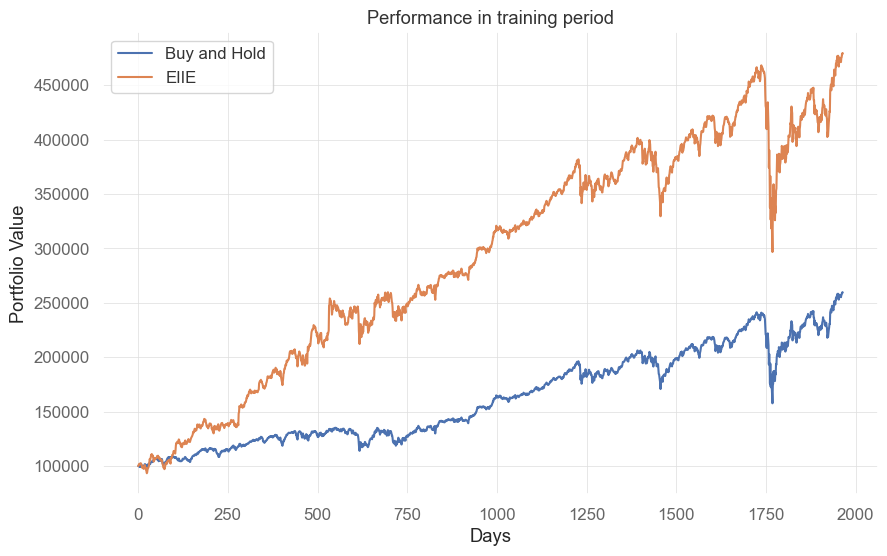

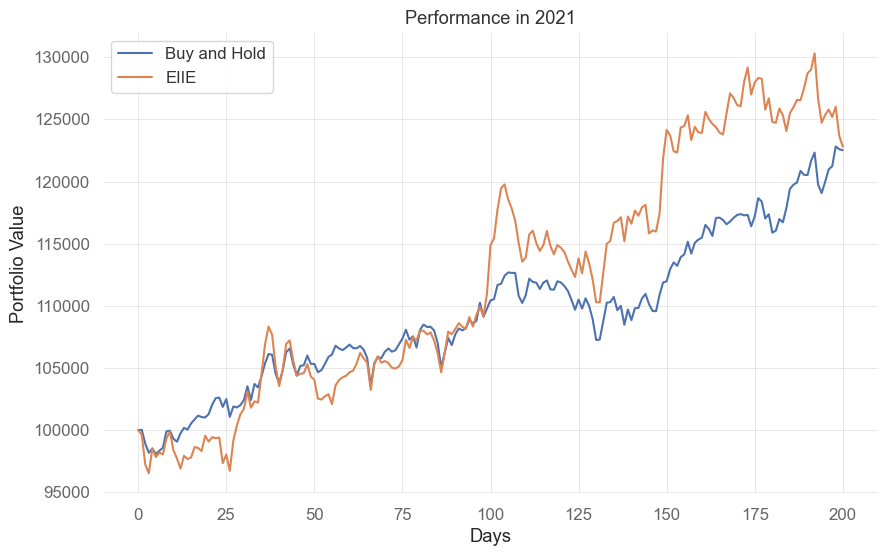

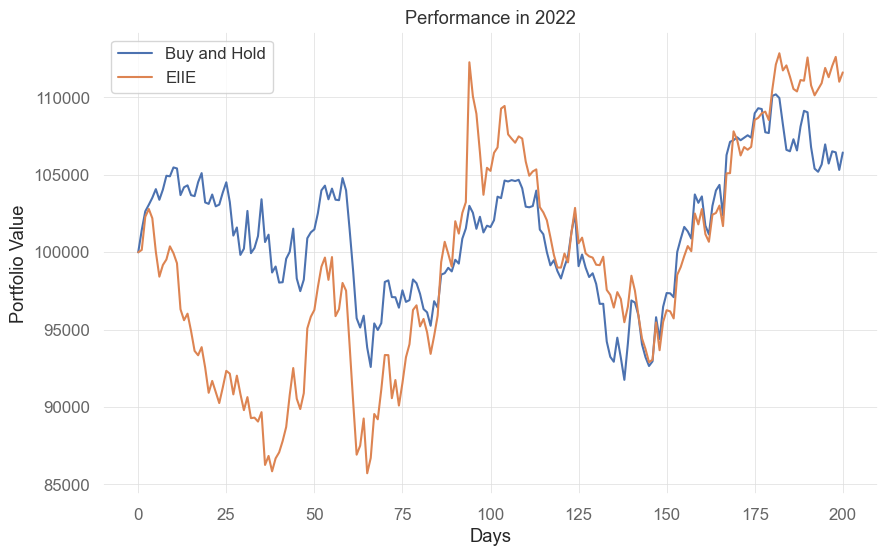

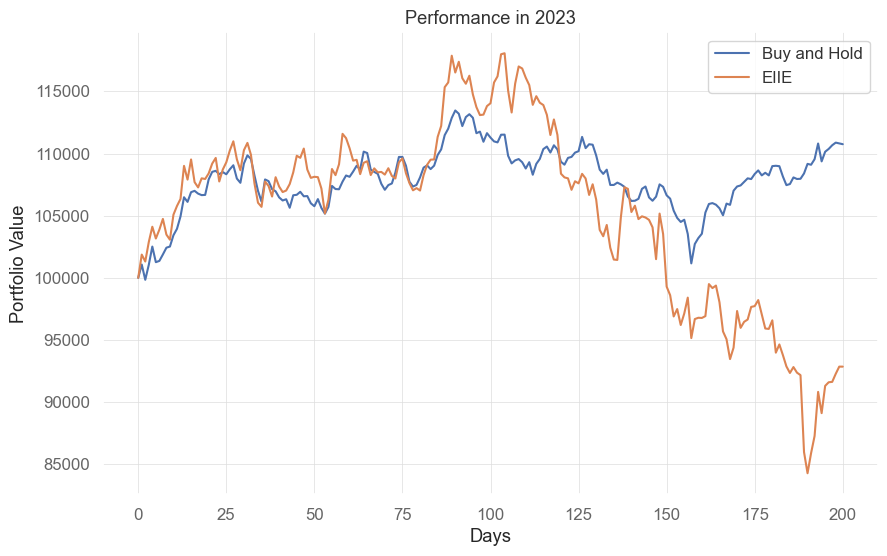

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["train"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

plt.plot(UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()